# Decision Tree Exercises

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

## Acquire

In [2]:
# Acquire Step
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [3]:
177 / 891

0.19865319865319866

## Prepare
1. Reduce obvious noise: 
    - Set `passenger_id` to be the index
    - Drop any duplicate columns
2. Look into the nulls
    - Drop the `deck` column due to so many nulls.
    - Fill `embark_town` with the most common value
    - `Age` column is ~20% null. I'm not comfortable dropping that many rows, so let's look into age.
3. One hot encode our string columns using `pd.get_dummies`
4. Split the data into train, validate, and test

In [4]:
# Reduce obvious noise
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [5]:
# What about nulls?
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [6]:
# Drop deck because there are far too many nulls
df = df.drop(columns=["deck"])

In [7]:
# Let's fill embark_town with the most common observation
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [8]:
# Let's investigate the observations with missing age
# My first thought was empty age values might indicate children
# Looks like most of these individuals were traveling alone
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

(<AxesSubplot:>, <AxesSubplot:>)

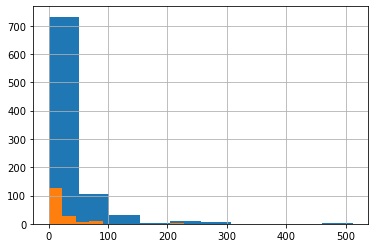

In [9]:
df.fare.hist(), no_age_info.fare.hist()

In [10]:
# Let's see how similar this group is to the population
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64


parch
Population:
0    0.760943
1    0.132435
2    0.089787
3    0.005612
5    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No age
0    0.887006
2    0.067797
1    0.045198
Name: parch, dtype: float64


embark_town
Population:
Southampton    0.724409
Cherbou

In [11]:
# Looking at the distribution of values, it appears that no age subgroup is very close to the population
# If we needed to be more certain, we could perform hypothesis testing
# It looks like there's nothing wildly different about the no age group compared to the population
# So we'll impute using the median age
df.age = df.age.fillna(value=df.age.median())

## Encoding reminder:
- Southampton, Queenstown, and Cherbourg were the embark towns
- If embark_town_Queenstown and embark_town_Southampton are both 0, then Cherbourg it is!

In [12]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [13]:
# Time to split!
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [14]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

## Onto Modeling

In [15]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [16]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.773481,0.801471,0.781124,0.787476,0.784216
recall,0.912052,0.570681,0.781124,0.741366,0.781124
f1-score,0.837070,0.666667,0.781124,0.751868,0.771715
support,307.000000,191.000000,0.781124,498.000000,498.000000


## Let's get loopy!

In [ ]:
# Let's 
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.815029    0.835526  0.821285    0.825278      0.822890
recall       0.918567    0.664921  0.821285    0.791744      0.821285
f1-score     0.863706    0.740525  0.821285    0.802115      0.816462
support    307.000000  191.000000  0.821285  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.836257    0.865385  0.845382    0.850821      0.847429
recall       0.931596    0.706806  0.845382    0.819201      0.845382
f1-score     0.881356    0.778098  0.845382    0.829727      0.841753
support    307.000000  191.000000  0.845382  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.842566    0.883871  0.855422    0.863218      0.858408
recall       0.941368    0.717277  0.855422    0.829323      0.855422
f1-score     

## As we might expect
- The more depth to the tree, the more the model fits to the training data
- But we need to expect more to the story!
- How well the model works on data it hasn't seen before?

In [ ]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

In [ ]:
# We can modify the above code to set a threshhold of difference
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
# And this will be a good example of a `break` statement in a loop

# Set our threshold for how overfit we'll tolerate
threshold = 0.10

models = []
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, min_samples_leaf=1, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)   
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    # Calculate the difference
    difference = in_sample_accuracy - out_of_sample_accuracy
    
    # Add a conditional to check vs. the threshold
    if difference > threshold:
        break
    
    # Formulate the output for each model's performance on train and validate
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "difference": difference
    }
    
    # Add the metrics dictionary to the list, so we can make a dataframe
    metrics.append(output)
    
    # Add the specific tree to a list of trained models
    models.append(forest)
    
df = pd.DataFrame(metrics)
df

#### The Above Code Replicated the Decision Tree Exercises w/ Random Forest

## Increasing `min_samples_per_leaf`, decreasing `max_depth`

In [ ]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

In [ ]:
sns.scatterplot(x="max_depth", y="difference", data=df)

In [ ]:
sns.scatterplot(x="min_samples_per_leaf", y="difference", data=df)

In [ ]:
sns.scatterplot(x="difference", y="validate_accuracy", data=df)

## What if we increase both `min_samples_per_leaf` and `max_depth`

In [ ]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df